In [ ]:
import sys
import os
import time
import asyncio
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from dotenv import load_dotenv

# Ensure we can import from src
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

try:
    from src.gateway.mt5_gateway import MT5Gateway
    from src.gateway.ccxt_gateway import CCXTGateway
    from src.config.logging_config import get_logger
    # Force legacy as requested
    USING_GATEWAY = False 
except ImportError:
    print("Could not import gateways. Falling back to direct implementation.")
    import MetaTrader5 as mt5
    import requests
    USING_GATEWAY = False

import MetaTrader5 as mt5
import requests

# Load params
load_dotenv()
SYMBOL_MT5 = os.getenv('MT5_SYMBOL', 'XAU')
SYMBOL_OKX_ENV = os.getenv('OKX_SYMBOL', 'XAU-USDT-SWAP') 

if "SWAP" not in SYMBOL_OKX_ENV and "USDT" in SYMBOL_OKX_ENV:
    SYMBOL_OKX = "XAU-USDT-SWAP"
else:
    SYMBOL_OKX = SYMBOL_OKX_ENV

print(f"Target Symbols -> MT5: {SYMBOL_MT5}, OKX: {SYMBOL_OKX}")

async def fetch_mt5_data_gateway(symbol, days=2):
    return pd.DataFrame()

async def fetch_okx_data_gateway(symbol, days=2):
    return pd.DataFrame()

async def run_validation_async():
    pass

def process_merged(df_mt5, df_okx):
    if df_mt5.empty or df_okx.empty:
        print("One of the data sources is empty.")
        return

    print("Step 3: Merging Data...")
    # Ensure indexes are sorted
    df_mt5 = df_mt5.sort_index()
    df_okx = df_okx.sort_index()
    
    df_merged = df_mt5.join(df_okx, how='inner')
    
    df_merged['spread'] = df_merged['mt5_close'] - df_merged['okx_close']
    
    print(f"Merged Records: {len(df_merged)}")
    
    print("\n--- Last 2 days of data (Sample) ---")
    cutoff = pd.Timestamp.now(tz='Asia/Shanghai') - pd.Timedelta(days=2)
    recent_df = df_merged[df_merged.index >= cutoff]
    
    if recent_df.empty:
        print("No intersecting data in the last 2 days.")
        print("Showing last 20 records available instead:")
        print(df_merged.tail(20))
    else:
        pd.set_option('display.max_rows', 100)
        print(recent_df.tail(50))
        
        print("\nSummary Stats (Last 2 Days):")
        print(recent_df.describe())
    return df_merged

def fetch_mt5_data_legacy(days=2):
    print("Initializing MT5...")
    if not mt5.initialize():
        print(f"MT5 Init failed: {mt5.last_error()}")
        return None

    if not mt5.symbol_select(SYMBOL_MT5, True):
         print(f"MT5 Symbol {SYMBOL_MT5} not found")
         mt5.shutdown()
         return None

    # Load manual offset preference from env
    env_offset_hours = os.getenv('MT5_UTC_OFFSET_HOURS')
    manual_offset_seconds = 0
    
    if env_offset_hours is not None:
        try:
             manual_offset_seconds = float(env_offset_hours) * 3600
             print(f"Using Manual MT5 Offset from .env: {env_offset_hours} hours ({manual_offset_seconds}s)")
        except:
             print("Invalid MT5_UTC_OFFSET_HOURS in .env")

    offset_seconds = manual_offset_seconds
    
    # Still fetch a tick just for info, but don't auto-adjust if manual is set
    tick = mt5.symbol_info_tick(SYMBOL_MT5)
    if tick:
        server_time = tick.time
        local_utc = datetime.now(timezone.utc).timestamp()
        
        # Verify what this manual offset implies
        implied_utc = server_time - offset_seconds
        implied_utc_dt = datetime.fromtimestamp(implied_utc, tz=timezone.utc)
        print(f"Server Time: {datetime.fromtimestamp(server_time, tz=timezone.utc)}")
        print(f"With Offset -{env_offset_hours}h => UTC: {implied_utc_dt}")
        print(f"Current Real UTC: {datetime.now(timezone.utc)}")
        
        diff_real = implied_utc - local_utc
        print(f"Discrepancy: {diff_real:.1f} seconds")
    
    # Use copy_rates_from_pos to ensure we get the ABSOLUTE LATEST bars
    count = days * 1440 + 60 
    print(f"Fetching last {count} bars from current position...")

    rates = mt5.copy_rates_from_pos(SYMBOL_MT5, mt5.TIMEFRAME_M1, 0, count)
    mt5.shutdown()
    
    if rates is None or len(rates) == 0:
        print("No rates returned")
        return pd.DataFrame()

    df = pd.DataFrame(rates)
    
    # Convert Server Time to UTC Timestamp using the fixed offset
    df['time_utc_ts'] = df['time'] - offset_seconds
    
    # Convert UTC to Asia/Shanghai (China Time)
    df['time'] = pd.to_datetime(df['time_utc_ts'], unit='s', utc=True).dt.tz_convert('Asia/Shanghai')
    df = df[['time', 'close']].rename(columns={'close': 'mt5_close'})
    df.set_index('time', inplace=True)
    
    # Debug last bar
    last_bar = df.index[-1]
    print(f"MT5 Last Bar Time: {last_bar} (Asia/Shanghai)")
    
    df = df[~df.index.duplicated(keep='last')]
    
    return df

def fetch_okx_data_legacy(days=2):
    base_url = "https://www.okx.com"
    end_ts = int(time.time() * 1000)
    start_ts = int((datetime.now(timezone.utc) - timedelta(days=days)).timestamp() * 1000)
    
    proxies = {
        'http': os.getenv('HTTP_PROXY'),
        'https': os.getenv('HTTPS_PROXY')
    }
    
    print(f"--- OKX TIME SYNC ---")
    print(f"System Time (ms): {end_ts}")
    print(f"Fetching OKX data (proxy: {proxies.get('http')})...")
    
    all_candles = []
    cursor = ""
    
    # First fetch to check latest
    first_batch = True
    
    while True:
        url = f"{base_url}/api/v5/market/history-candles?instId={SYMBOL_OKX}&bar=1m&limit=100"
        if cursor:
            url += f"&after={cursor}"
            
        success = False
        data = None
        for attempt in range(3):
            try:
                r = requests.get(url, timeout=30, proxies=proxies)
                data = r.json()
                success = True
                break
            except Exception as e:
                print(f"Fetch error (attempt {attempt+1}/3): {e}")
                time.sleep(1)
        
        if not success:
            print("Max retries exceeded for this batch. Stopping fetch.")
            break
            
        if data['code'] != '0':
            print(f"OKX Error: {data}")
            break
            
        candles = data['data']
        if not candles:
            break
            
        if first_batch:
            latest = candles[0]
            latest_ts = int(latest[0])
            print(f"OKX Latest Candle TS: {latest_ts}")
            print(f"Diff from System:    {end_ts - latest_ts} ms ({(end_ts - latest_ts)/1000/60:.1f} min)")
            first_batch = False
            
        all_candles.extend(candles)
        cursor = candles[-1][0]
        
        last_ts = int(cursor)
        if last_ts < start_ts:
            break
            
        time.sleep(0.1)

    if not all_candles:
        return pd.DataFrame()

    df = pd.DataFrame(all_candles, columns=['ts', 'o', 'h', 'l', 'c', 'v', 'vccy', 'vc', 'confirm'])
    
    # OKX returns timestamps in milliseconds (UTC)
    # Convert directly to Asia/Shanghai
    df['time'] = pd.to_datetime(df['ts'].astype('int64'), unit='ms', utc=True).dt.tz_convert('Asia/Shanghai')
    
    df['okx_close'] = df['c'].astype(float)
    df = df[['time', 'okx_close']]
    df.set_index('time', inplace=True)
    df = df.sort_index()
    
    last_bar = df.index[-1]
    print(f"OKX Last Bar Time: {last_bar} (Asia/Shanghai)")
    
    return df

def fetch_ccxt_simple(exchange_name, symbol, days=2):
    try:
        import ccxt
    except ImportError:
        print(f"CCXT not installed, skipping {exchange_name}")
        return pd.DataFrame()
        
    print(f"Fetching {exchange_name} {symbol}...")
    
    proxies = {
        'http': os.getenv('HTTP_PROXY'),
        'https': os.getenv('HTTPS_PROXY')
    }
    
    try:
        exchange_class = getattr(ccxt, exchange_name)
    except AttributeError:
        print(f"Exchange {exchange_name} not found in ccxt")
        return pd.DataFrame()

    options = {
        'proxies': proxies, 
        'enableRateLimit': True,
        'options': {'defaultType': 'swap'} # Default to swap/future for most
    }
    
    # Specific tweaks
    limit_per_req = 1000
    if exchange_name == 'binance':
        options['options']['defaultType'] = 'future'
    elif exchange_name == 'gate':
        options['options']['defaultType'] = 'swap' # Gate futures
    elif exchange_name == 'okx':
        # OKX limits: 100 candles per request for history. 
        # CCXT default fetch_ohlcv uses 'market/candles' which is limited to 1440 bars.
        # To get more history, we generally need to manage pagination carefully or use specific params.
        # Here we reduce requested limit to match API max to be safe.
        limit_per_req = 100
        
    ex = exchange_class(options)
    
    # Time calculations
    try:
        ex.load_markets()
    except Exception as e:
        print(f"Error loading markets for {exchange_name}: {e}")
        return pd.DataFrame()
        
    if symbol not in ex.markets:
        print(f"Symbol {symbol} not found in {exchange_name}. Available: {list(ex.markets.keys())[:5]}...")
        # Try finding a matching symbol
        candidates = [s for s in ex.markets if 'XAU' in s and 'USDT' in s]
        if candidates:
            print(f"Trying alternative symbol: {candidates[0]}")
            symbol = candidates[0]
        else:
            return pd.DataFrame()

    end_ts = ex.milliseconds()
    start_ts = end_ts - (days * 24 * 60 * 60 * 1000)
    
    all_candles = []
    current_start = start_ts
    
    # Fetch Loop
    while current_start < end_ts:
        try:
            ohlcv = ex.fetch_ohlcv(symbol, '1m', since=current_start, limit=limit_per_req)
            if not ohlcv:
                print(f"{exchange_name} returned 0 candles at {pd.to_datetime(current_start, unit='ms')}")
                break
            
            count_fetched = len(ohlcv)
            # print(f"Fetched {count_fetched} candles starting {pd.to_datetime(ohlcv[0][0], unit='ms')}")
            
            all_candles.extend(ohlcv)
            
            # Update start for next batch
            last_candle_ts = ohlcv[-1][0]
            if last_candle_ts <= current_start:
                 # Prevent infinite loop if exchange returns same candle
                 current_start += 60000 * len(ohlcv)
            else:
                 current_start = last_candle_ts + 60000
                 
            # Remove strict limit check that breaks on gaps
            # if len(ohlcv) < 1000:
            #    break
            
            # Instead, check if we've reached the target end time
            if last_candle_ts >= end_ts - 60000:
                print(f"{exchange_name} reached end time.")
                break
                
            time.sleep(ex.rateLimit / 1000.0) # Respect rate limit
            
        except Exception as e:
            print(f"Error fetching {exchange_name}: {e}")
            break
            
    if not all_candles:
        return pd.DataFrame()
        
    df = pd.DataFrame(all_candles, columns=['ts', 'o', 'h', 'l', 'c', 'v'])
    
    # Process
    df['time'] = pd.to_datetime(df['ts'], unit='ms', utc=True).dt.tz_convert('Asia/Shanghai')
    df[f'{exchange_name}_close'] = df['c'].astype(float)
    df = df[['time', f'{exchange_name}_close']]
    df.set_index('time', inplace=True)
    
    # Deduplicates
    df = df[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    
    if not df.empty:
        print(f"{exchange_name} Records: {len(df)} (Last: {df.index[-1]})")
        
    return df

def main():
    if USING_GATEWAY:
        pass
    else:
        print("Using Legacy implementation.")
        print("Step 1: Fetching MT5 History...")



Target Symbols -> MT5: XAU, OKX: XAU-USDT-SWAP


In [73]:
df_mt5 = fetch_mt5_data_legacy(5)
df_okx = fetch_okx_data_legacy(5)

df_bybit = fetch_ccxt_simple('bybit', 'XAU/USDT:USDT',5)
df_binance = fetch_ccxt_simple('binance', 'XAU/USDT:USDT', 5) # Often XAUUSDT perpetual
df_gate = fetch_ccxt_simple('gate', 'XAU/USDT:USDT', 5)

df_mt5 = df_mt5.sort_index()
df_okx = df_okx.sort_index()
df_bybit = df_bybit.sort_index()
df_binance = df_binance.sort_index()
df_gate = df_gate.sort_index()

df_merged = df_mt5.join(df_okx, how='inner').join(df_bybit, how='inner').join(df_binance, how='inner').join(df_gate, how='inner')
df_merged['okx_spread'] = df_merged['mt5_close'] - df_merged['okx_close']
df_merged['bybit_spread'] = df_merged['mt5_close'] - df_merged['bybit_close']
df_merged['binance_spread'] = df_merged['mt5_close'] - df_merged['binance_close']
df_merged['gate_spread'] = df_merged['mt5_close'] - df_merged['gate_close']

Initializing MT5...
Using Manual MT5 Offset from .env: 8 hours (28800.0s)
Server Time: 2026-02-07 05:49:58+00:00
With Offset -8h => UTC: 2026-02-06 21:49:58+00:00
Current Real UTC: 2026-02-08 16:22:37.484872+00:00
Discrepancy: -153159.5 seconds
Fetching last 7260 bars from current position...
MT5 Last Bar Time: 2026-02-07 05:49:00+08:00 (Asia/Shanghai)
--- OKX TIME SYNC ---
System Time (ms): 1770567757492
Fetching OKX data (proxy: http://127.0.0.1:7890)...
OKX Latest Candle TS: 1770567660000
Diff from System:    97492 ms (1.6 min)
OKX Latest Candle TS: 1770567660000
Diff from System:    97492 ms (1.6 min)
Fetch error (attempt 1/3): HTTPSConnectionPool(host='www.okx.com', port=443): Max retries exceeded with url: /api/v5/market/history-candles?instId=XAU-USDT-SWAP&bar=1m&limit=100&after=1770507720000 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))
Fetch error (attempt 1/3): HTTPSConnectionPool(host='www.okx.

In [74]:
df_merged

,mt5_close,okx_close,bybit_close,binance_close,gate_close,okx_spread,bybit_spread,binance_spread,gate_spread
time,,,,,,,,,
2026-02-04 00:25:00+08:00,4971.57,4974.8,4970.4,4971.92,4974.39,-3.23,1.17,-0.35,-2.82
2026-02-04 00:26:00+08:00,4972.34,4976.1,4971.0,4972.06,4975.30,-3.76,1.34,0.28,-2.96
2026-02-04 00:27:00+08:00,4978.11,4983.1,4976.5,4979.12,4982.46,-4.99,1.61,-1.01,-4.35
2026-02-04 00:28:00+08:00,4976.61,4980.5,4972.2,4977.59,4977.94,-3.89,4.41,-0.98,-1.33
2026-02-04 00:29:00+08:00,4973.05,4978.1,4969.4,4973.94,4975.22,-5.05,3.65,-0.89,-2.17
...,...,...,...,...,...,...,...,...,...
2026-02-07 05:45:00+08:00,4958.58,4932.0,4916.3,4955.46,4961.56,26.58,42.28,3.12,-2.98
2026-02-07 05:46:00+08:00,4958.42,4931.4,4916.1,4954.63,4960.60,27.02,42.32,3.79,-2.18
2026-02-07 05:47:00+08:00,4960.32,4932.8,4917.2,4956.85,4962.22,27.52,43.12,3.47,-1.90


<Axes: xlabel='time'>

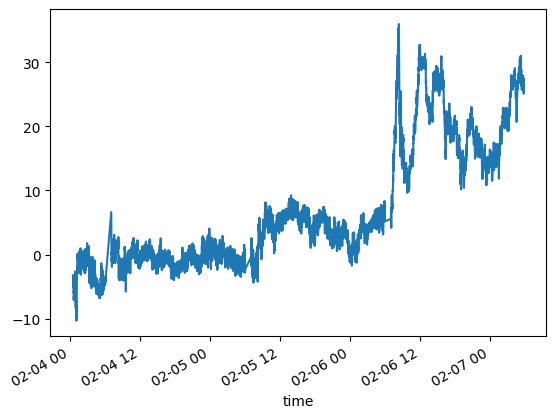

In [75]:
df_merged['okx_spread'].plot()

In [70]:
df_okx=fetch_ccxt_simple('okx', 'XAU/USDT:USDT', 2)

Fetching okx XAU/USDT:USDT...
okx reached end time.
okx Records: 900 (Last: 2026-02-09 00:19:00+08:00)
okx reached end time.
okx Records: 900 (Last: 2026-02-09 00:19:00+08:00)


Fetching okx XAU/USDT:USDT...
okx reached end time.
okx Records: 900 (Last: 2026-02-09 00:16:00+08:00)
okx reached end time.
okx Records: 900 (Last: 2026-02-09 00:16:00+08:00)


Fetching binance XAU/USDT:USDT...
binance reached end time.
binance Records: 2880 (Last: 2026-02-09 00:15:00+08:00)
binance reached end time.
binance Records: 2880 (Last: 2026-02-09 00:15:00+08:00)


In [63]:
df_binance

,binance_close
time,
2026-02-07 00:16:00+08:00,4934.67
2026-02-07 00:17:00+08:00,4938.49
2026-02-07 00:18:00+08:00,4942.51
2026-02-07 00:19:00+08:00,4941.48
2026-02-07 00:20:00+08:00,4941.50
...,...
2026-02-09 00:11:00+08:00,4978.35
2026-02-09 00:12:00+08:00,4977.38
2026-02-09 00:13:00+08:00,4977.40


Fetching gate XAU/USDT:USDT...
gate reached end time.
gate Records: 2880 (Last: 2026-02-09 00:15:00+08:00)
gate reached end time.
gate Records: 2880 (Last: 2026-02-09 00:15:00+08:00)


In [65]:
df_gate

,gate_close
time,
2026-02-07 00:16:00+08:00,4936.00
2026-02-07 00:17:00+08:00,4940.13
2026-02-07 00:18:00+08:00,4943.83
2026-02-07 00:19:00+08:00,4942.60
2026-02-07 00:20:00+08:00,4943.88
...,...
2026-02-09 00:11:00+08:00,4973.54
2026-02-09 00:12:00+08:00,4973.75
2026-02-09 00:13:00+08:00,4972.03


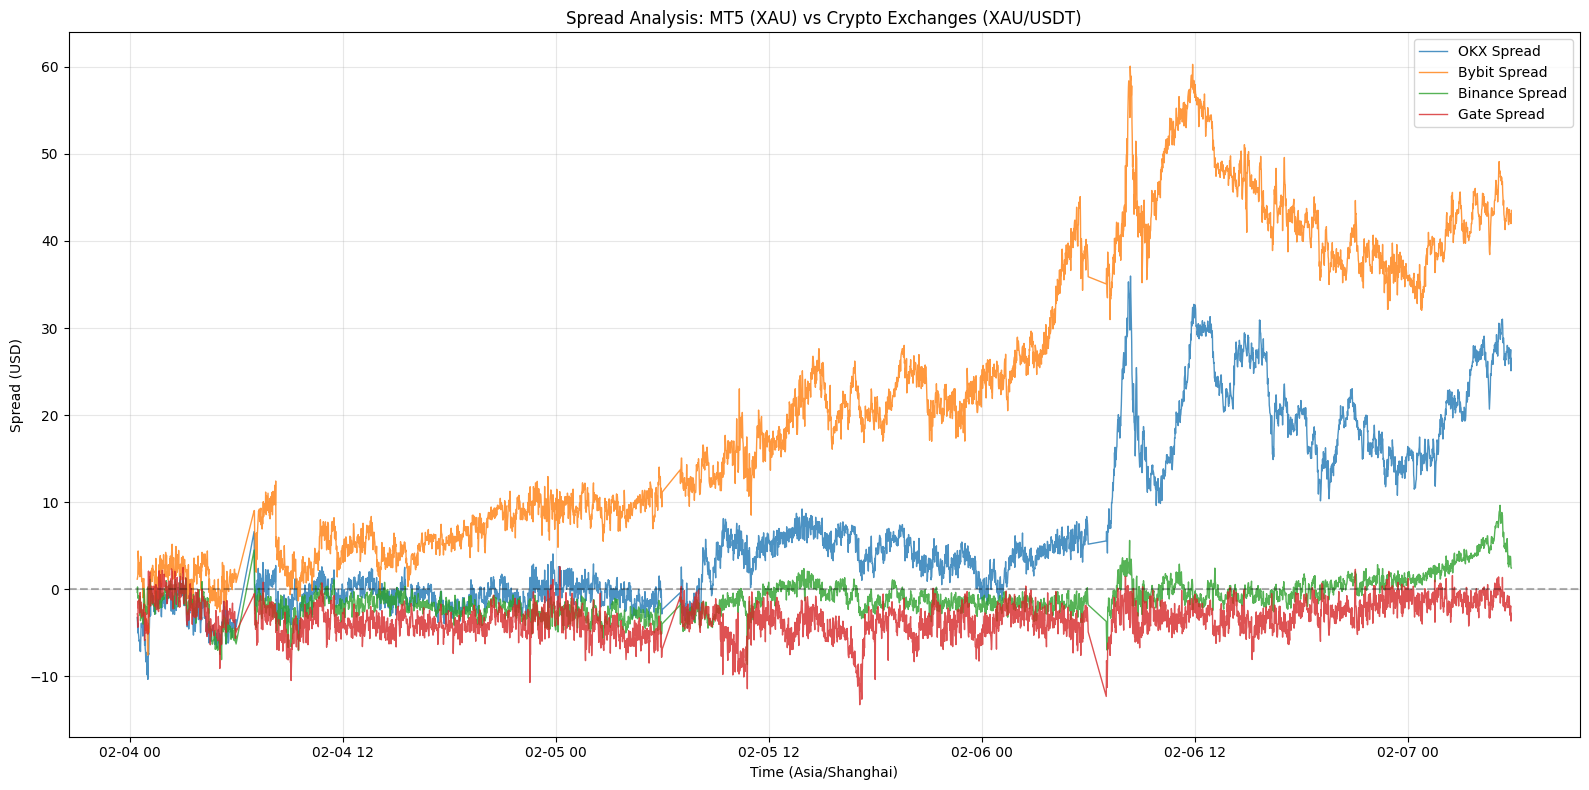

In [76]:
import matplotlib.pyplot as plt

# Check if df_merged exists and is not empty
if 'df_merged' in locals() and not df_merged.empty:
    plt.figure(figsize=(16, 8))
    
    # Plot each spread if the column exists
    if 'okx_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['okx_spread'], label='OKX Spread', alpha=0.8, linewidth=1)
        
    if 'bybit_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['bybit_spread'], label='Bybit Spread', alpha=0.8, linewidth=1)
        
    if 'binance_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['binance_spread'], label='Binance Spread', alpha=0.8, linewidth=1)
        
    if 'gate_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['gate_spread'], label='Gate Spread', alpha=0.8, linewidth=1)

    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.title('Spread Analysis: MT5 (XAU) vs Crypto Exchanges (XAU/USDT)')
    plt.xlabel('Time (Asia/Shanghai)')
    plt.ylabel('Spread (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("df_merged is not available or empty. Please run the data fetching cells first.")

In [ ]:
import matplotlib.pyplot as plt

# Check if data is available
if 'df_merged' in locals() and not df_merged.empty:
    plt.figure(figsize=(15, 8))
    
    # Plot each spread
    if 'okx_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['okx_spread'], label='OKX Spread', alpha=0.8, linewidth=1)
    if 'bybit_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['bybit_spread'], label='Bybit Spread', alpha=0.8, linewidth=1)
    if 'binance_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['binance_spread'], label='Binance Spread', alpha=0.8, linewidth=1)
    if 'gate_spread' in df_merged.columns:
        plt.plot(df_merged.index, df_merged['gate_spread'], label='Gate Spread', alpha=0.8, linewidth=1)

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    plt.title('Arbitrage Spreads: MT5 (XAU) - Exchange (XAU/USDT)')
    plt.xlabel('Time (Asia/Shanghai)')
    plt.ylabel('Spread Price Diff')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("df_merged is not defined or empty. Please run the merge cell first.")